# **STAT306 Project**
group members: Felix Li, Amin A. Mezouari, David Perez, JingHan Xu

In [1]:
library(tidyverse)
library(tidymodels)
library(leaps)
library(glmnet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.1
✔ infer        1.0.3     ✔ workflows    1.1.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.2     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

## Raw data

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
dir.create("data")
destFile <- "data/localfile.data"
download.file(url, destFile)

In [3]:
raw_mpg_data <- read.delim("data/localfile.data", sep= "", header = FALSE)

mpg_data_2 <- raw_mpg_data %>% mutate(mpg = V1, cylinders = V2, displacement =V3, hoursepower = V4, 
                    weight = V5, acceleration = V6, model_year = V7, origin = V8, car_name = V9)

mpg_data_tidy<- mpg_data_2 %>% select(mpg,cylinders,displacement,hoursepower,weight,acceleration,model_year,origin,car_name)
head(mpg_data_tidy)

,mpg,cylinders,displacement,hoursepower,weight,acceleration,model_year,origin,car_name
,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
1,18,8,307,130.0,3504,12.0,70,1,chevrolet chevelle malibu
2,15,8,350,165.0,3693,11.5,70,1,buick skylark 320
3,18,8,318,150.0,3436,11.0,70,1,plymouth satellite
4,16,8,304,150.0,3433,12.0,70,1,amc rebel sst
5,17,8,302,140.0,3449,10.5,70,1,ford torino
6,15,8,429,198.0,4341,10.0,70,1,ford galaxie 500


# Analysis

In [7]:
mpg_data_tidy$cylinders <- as.factor(mpg_data_tidy$cylinders)

mpg_data_tidy$hoursepower <- as.integer(mpg_data_tidy$hoursepower)

mpg_data <- mpg_data_tidy %>% 
        select(mpg,cylinders,displacement,hoursepower,weight,acceleration) %>%
        filter(!is.na(mpg_data_tidy$hoursepower)) 


head(mpg_data)

,mpg,cylinders,displacement,hoursepower,weight,acceleration
,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
1,18,8,307,130,3504,12.0
2,15,8,350,165,3693,11.5
3,18,8,318,150,3436,11.0
4,16,8,304,150,3433,12.0
5,17,8,302,140,3449,10.5
6,15,8,429,198,4341,10.0


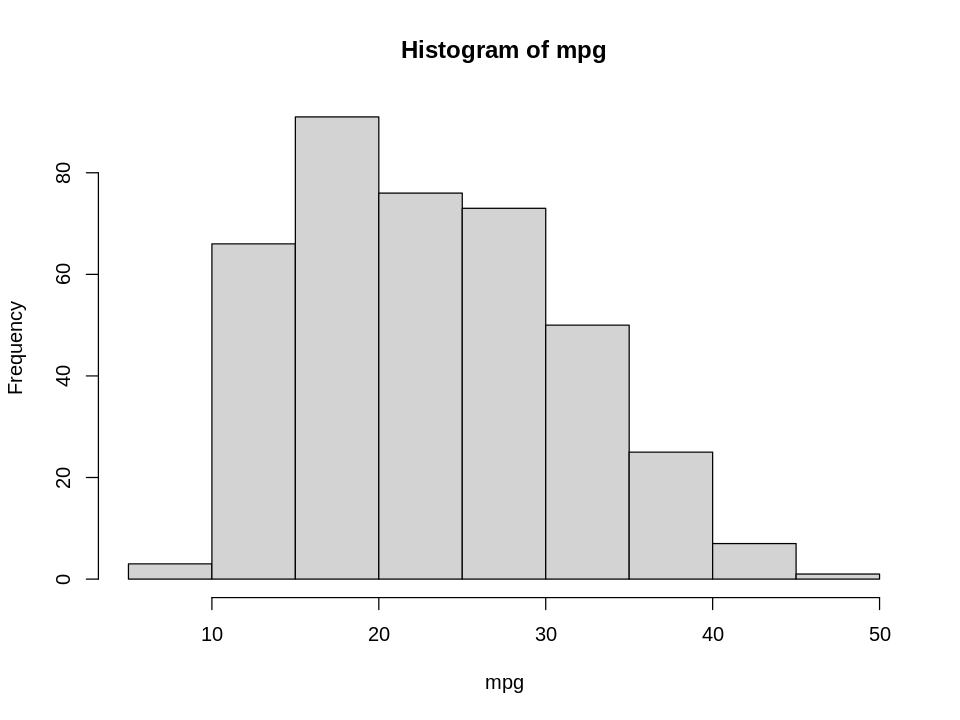

In [13]:
hist(mpg_data$mpg,
    main="Histogram of mpg",
    xlab="mpg")

The distribution fo mpg is roughly a normal distribution

In [10]:
fit_full <- lm(mpg ~ ., data =mpg_data)
tidy(fit_full)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),38.8797135169,3.0568096655,12.71904952,3.699781e-31
cylinders4,7.2195952224,2.1036080781,3.43200585,6.644740e-04
cylinders5,9.2635725470,3.1611669676,2.93042811,3.587773e-03
cylinders6,3.4582041828,2.3390418059,1.47847045,1.401038e-01
cylinders8,6.0961268262,2.7080015421,2.25115338,2.494217e-02
displacement,-0.0008322167,0.0086454769,-0.09626036,9.233641e-01
hoursepower,-0.0673907209,0.0163483803,-4.12216498,4.604209e-05
weight,-0.0043707459,0.0007889386,-5.54003329,5.632427e-08
acceleration,-0.0828388501,0.1197355869,-0.69184820,4.894519e-01


It seems that cylinders6, displacement, and acceleration are not significant, since the p-values for those are higher than 0.05
We will present both the forward and backward selection and plot the cp graph to determine which is the best model

## forward selection 

In [14]:
mpg_forward_sel <- regsubsets(
  x = mpg ~ ., nvmax = 5,
  data = mpg_data,
  method = "forward",
)
    
mpg_forward_summary <- summary(mpg_forward_sel)
mpg_forward_summary

Subset selection object
Call: regsubsets.formula(x = mpg ~ ., nvmax = 5, data = mpg_data, method = "forward", 
    )
8 Variables  (and intercept)
             Forced in Forced out
cylinders4       FALSE      FALSE
cylinders5       FALSE      FALSE
cylinders6       FALSE      FALSE
cylinders8       FALSE      FALSE
displacement     FALSE      FALSE
hoursepower      FALSE      FALSE
weight           FALSE      FALSE
acceleration     FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: forward
         cylinders4 cylinders5 cylinders6 cylinders8 displacement hoursepower
1  ( 1 ) " "        " "        " "        " "        " "          " "        
2  ( 1 ) "*"        " "        " "        " "        " "          " "        
3  ( 1 ) "*"        " "        " "        " "        " "          "*"        
4  ( 1 ) "*"        " "        " "        "*"        " "          "*"        
5  ( 1 ) "*"        "*"        " "        "*"        " "          "*"        
         weight acce

## Backward selection 

In [17]:
mpg_backward_sel <- regsubsets(
  x = mpg ~ ., nvmax = 5,
  data = mpg_data,
  method = "backward",
)
    
mpg_backward_summary <- summary(mpg_backward_sel)
mpg_backward_summary

Subset selection object
Call: regsubsets.formula(x = mpg ~ ., nvmax = 5, data = mpg_data, method = "backward", 
    )
8 Variables  (and intercept)
             Forced in Forced out
cylinders4       FALSE      FALSE
cylinders5       FALSE      FALSE
cylinders6       FALSE      FALSE
cylinders8       FALSE      FALSE
displacement     FALSE      FALSE
hoursepower      FALSE      FALSE
weight           FALSE      FALSE
acceleration     FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: backward
         cylinders4 cylinders5 cylinders6 cylinders8 displacement hoursepower
1  ( 1 ) " "        " "        " "        " "        " "          " "        
2  ( 1 ) "*"        " "        " "        " "        " "          " "        
3  ( 1 ) "*"        " "        " "        " "        " "          "*"        
4  ( 1 ) "*"        " "        " "        "*"        " "          "*"        
5  ( 1 ) "*"        "*"        " "        "*"        " "          "*"        
         weight ac

**Both the forward and backward selection gives the same output**

In [ ]:
mpg_forward_summary_df <- tibble(
    n_input_variables = 1:5,
    RSQ = mpg_forward_summary$rsq,
    RSS = mpg_forward_summary$rss,
    ADJ.R2 = mpg_forward_summary$adjr2,
    Cp = mpg_forward_summary$cp,
    BIC = mpg_forward_summary$bic,
)
mpg_forward_summary_df

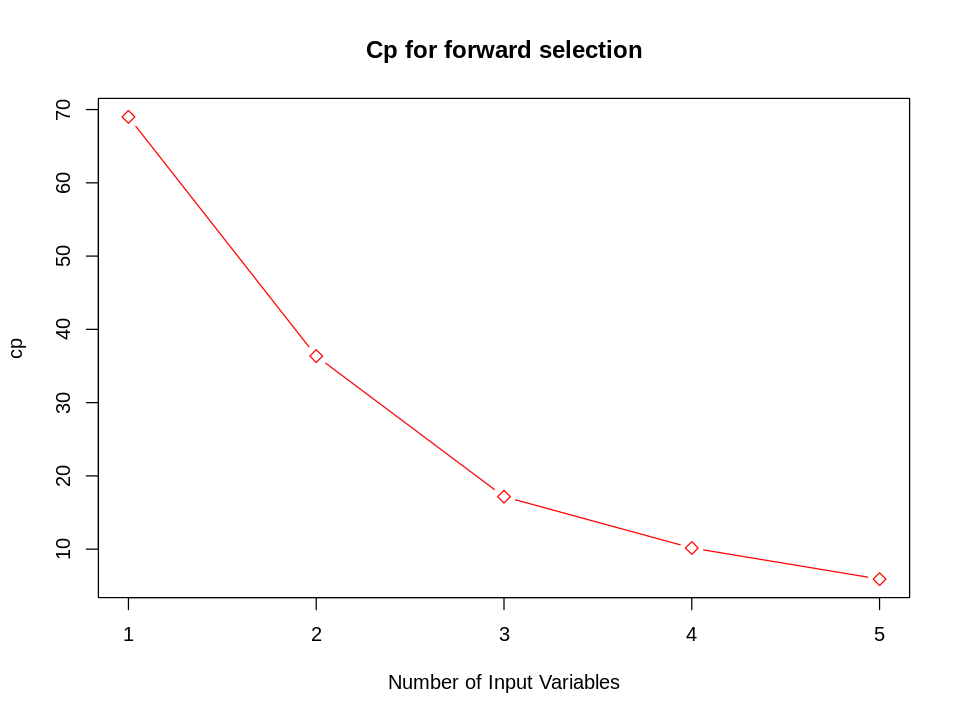

In [19]:
plot(summary(mpg_forward_sel)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "cp", type = "b", pch = 5,
  col = "red"
)